In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.utils.class_weight import compute_sample_weight
from matplotlib import ticker
from matplotlib.colors import Normalize

#https://www.sciencedirect.com/science/article/pii/S0301479723027299?via%3Dihub#bib18
#Use kernal 3.11.5

In [6]:
# data = '/home/anna/Desktop/Machine Learning/ml4e-john-d/Final_Project/ML Final Project Dataset.csv'
data = '/Users/johndocter/Documents/Boulder/Courses/ML/ml4e-john-d/Final_Project/ML Final Project Dataset.csv'
df1 = pd.read_csv(data)
df2 = df1.drop(columns=['reference', 'ID', 'Study'])
sites = df2['site']

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

# print(sites)

### Looking At Data Balance

In [7]:
count = df2['site'].value_counts()
print(count)

site
Inner Mongolia, China                                                          189
Qinghai-Tibetan Plateau, China                                                  89
West Bengal, India                                                              66
South Sumatra, Indonesia                                                        42
New South Wales, Australia                                                      41
Hunan Province, China                                                           36
North American                                                                  36
Birsa Agricultural University, India                                            33
Guangdong Province, South China                                                 30
Fujian, China                                                                   24
Florida                                                                         20
Georgia, USA                                                                    18

### Data Processing: One Hot Encoding Categorial Data, Dropping Unnessecary , and Weight Values to Balance Data

In [8]:
##Form One Hot Encode
form_encoded = pd.get_dummies(df2['Form'])
df3 = pd.concat([df2, form_encoded], axis = 1)
df3['Ca(H2PO4)2'] = df3['Ca(H2PO4)2'].astype(int)
df3['KH2PO4'] = df3['KH2PO4'].astype(int)
df3['NaH2PO4'] = df3['NaH2PO4'].astype(int)
df3['Rock phosphate'] = df3['Rock phosphate'].astype(int)
# df3[:30]

#Environment One Hot Encoding
Env_encode = pd.get_dummies(df3['Environment'])
df4 = pd.concat([df3, Env_encode], axis = 1)
# df4[:10]
df4['Cropland'] = df4['Cropland'].astype(int)
df4['Forest'] = df4['Forest'].astype(int)
df4['Grassland'] = df4['Grassland'].astype(int)
df4['Pot'] = df4['Pot'].astype(int)

# df4[:15]

#Mode One Hot 
mode_encode = pd.get_dummies(df4['Mode'])
df5 = pd.concat([df4, mode_encode], axis=1)
df5['Particle'] = df5['Particle'].astype(int)
df5['Solution'] = df5['Solution'].astype(int)
df5[:10]

df6 = df5.drop(columns=['Mode','Form', 'Environment'])

#Carbon One Hot
carbon_encode = pd.get_dummies(df6['Variable (predictors)'])
df7 = pd.concat([df6, carbon_encode], axis = 1)
df7['AGB'] = df7['AGB'].astype(int)
df7['ANPP'] = df7['ANPP'].astype(int)
df7['BNPP'] = df7['BNPP'].astype(int)
df7['LM'] = df7['LM'].astype(int)
df7['MBC'] = df7['MBC'].astype(int)
df7['NPP'] = df7['NPP'].astype(int)
df7['RB'] = df7['RB'].astype(int)
df7['SOC'] = df7['SOC'].astype(int)
df7['SR'] = df7['SR'].astype(int)
df7['TB'] = df7['TB'].astype(int)

# df7[:10]

df8 = df7.drop(columns=['Variable (predictors)'])

df8[:10]


df8['count'] = df8['site'].map(df8['site'].value_counts())
df8['Weight'] = 1/df8['count']
df9 = df8.drop(columns=['Weighting Factors', 'site'])
# print(df9.columns)
df9[:15]

,latitude,longitude,Mean Annual Precipitation,Mean Annual Temperature,Aridity,pH,Phos Application Rate,Experimental Duration,Background P Content,yi (response),Ca(H2PO4)2,KH2PO4,NaH2PO4,Rock phosphate,Cropland,Forest,Grassland,Pot,Particle,Solution,AGB,ANPP,BNPP,LM,MBC,NPP,RB,SOC,SR,TB,count,Weight
0,35.70,-78.70,1050.0,15.2,0.240000,4.6,80.7,7.5,543.4,0.243309,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,2,0.5
1,35.70,-78.70,1050.0,15.2,0.240000,4.6,48.8,4.0,592.1,0.091434,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,2,0.5
2,-43.03,171.75,1300.0,9.0,0.146154,5.8,72.5,4.8,567.1,0.017392,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,10,0.1
3,-43.03,171.75,1300.0,9.0,0.146154,5.8,61.9,2.5,701.6,0.017392,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,10,0.1
4,-43.03,171.75,1300.0,9.0,0.146154,5.8,42.5,3.4,609.3,0.034486,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,10,0.1
5,-43.03,171.75,1300.0,9.0,0.146154,5.8,64.4,3.9,579.3,0.084083,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,10,0.1
6,-43.03,171.75,1300.0,9.0,0.146154,5.8,68.2,2.8,662.7,0.034486,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,10,0.1
7,-43.03,171.75,1300.0,9.0,0.146154,5.8,22.6,2.1,497.9,-0.162519,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,10,0.1
8,-43.03,171.75,1300.0,9.0,0.146154,5.8,90.9,11.9,414.4,0.371564,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,10,0.1
9,-43.03,171.75,1300.0,9.0,0.146154,5.8,131.4,4.8,327.7,0.788457,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,10,0.1


### Initializing the Model (Realizing this step is probably unnecessary)

In [9]:
xgb_df = xgb.DMatrix(data=df9.drop(columns=['yi (response)']), label=df9['yi (response)'])
#dropped column is the dataframe used to predict. 
#label is what we are trying to predict. 

### GridSearch / Hyperparameter Tuning, Then Splitting Data into Training and Test Data

In [10]:
#https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d
model = xgb.XGBRegressor(n_estimators = 200) #n_estimator is the number of trees trained, each tree will correct the errors of the previous one. More estimators = better predicition but more computation time
param_grid = {
    'eta': [0.3, 0.1, 0.01, 0.001],              # Learning rate, ranges from 0.01 to 0.3
    'max_depth': [3, 4, 5, 10],                  # Maximum depth of a tree, frmo 3 to 10 
    'subsample': [0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0],   # Subsample ratio of the training instances, from 0.5 to 10 
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],        # Subsample ratio of columns when constructing each tree, 0 to 1.0
    'max_delta_step': [0, 1, 3, 5, 7, 10]          # limits steps size for each tree's weight estimation, may help control for imbalance data, 0 to 10 
    # 'n_estimators': [1, 2, 3, 10, 15, 20]        # Number of boosting rounds (equivalent to nrounds)
}
x= df9.drop(columns=['yi (response)'])
y = df9['yi (response)']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=100) 


#### Extracting Weights to Fill in Sample Weights Argument when Fitting Model

In [11]:
# print(x_train) #I want to see what weights are associated with what parts of the training data. 
weights = x_train['Weight']
# print(weights)


In [12]:

# print(x_train)
# print(x_test)
# print(y_train)
# print(y_test)
# test_size = 20% testing, 80% training
#random_state = sets the random seed - keep it the same for reproducability 
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
#cv = 5: number of folds for CValidation. Model data will be split into 5 folds, using different combinations as the training and test set - keep in mind this is for the gridsearch algorithm, and is different than the training and test split. 
#KCV is for optimizing the gridsearch and can be thought of as part of the training step, rather than the final evaluation. 
#n_jobs = -1 specifies the alg to use all available CPU cores. 
best_model = grid_search.fit(x_train, y_train, sample_weight=weights) #this is the model variable

bep = grid_search.best_params_
print("Best Parameters are: ", bep) #Combination of Hyperparameters from GridsearchCV with cross validation that results in the lowest mean squared error

y_pred = grid_search.predict(x_test)
test_mse = mean_squared_error(y_test, y_pred) # Measure of the average squared difference between the predicted values and the actual values. The lower the better, or the closer the predictions are to the true values
print('Mean Squared Error:', test_mse)

rmse = np.sqrt(test_mse) 
print("Root Mean Squared Error is:", rmse) #

mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error is: ', mae) #Absolute difference between the predicted and actual value: 16% difference. 

r2 = r2_score(y_test, y_pred) #Proportion of the variance in the target variable that is preditble from the independant variables. 1 is a perfect fit, 0 is no relationship. 





#(N_estimators = 150), TMSE = 0.066, no weighting


Best Parameters are:  {'colsample_bytree': 0.8, 'eta': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'subsample': 1.0}
Mean Squared Error: 0.0767848565158282
Root Mean Squared Error is: 0.27710080569321377
Mean Absolute Error is:  0.1561311544947226


In [14]:
print('R2 score is', r2)

R2 score is 0.6602510371174564


### Predictions Formatted and Looked At

In [23]:

pred2 = np.array([y_pred])
print((pred2))
pred3 = pred2.flatten()
# print(pred3)
pred4 = (np.exp(pred3)-1) *100 #Brett - this is a calculation from the paper for turning the response variable into percentages. I do not know why a few are huge...
# array_no_sci = np.array2string(pred3, suppress_small=True)
# print(array_no_sci)

# print(pred4)

[[ 2.10087925e-01  5.56542873e-01 -3.91819961e-02 -3.13274525e-02
   1.59285411e-01  3.98742378e-01  1.37236416e-01 -1.82267711e-01
  -2.48883329e-02 -1.70570035e-02  2.09618464e-01 -1.37949780e-01
   4.57584336e-02  1.20359100e-01  1.31787434e-01  1.20791459e+00
  -2.00806428e-02  9.93252546e-02 -5.41810133e-02  7.07390010e-02
   3.05014346e-02  9.42935199e-02  1.59339949e-01  2.27124598e-02
  -5.56422323e-02  3.42780262e-01  8.05432256e-03 -4.15391847e-02
  -5.75252213e-02 -1.97457105e-01  1.54090777e-01  7.89724648e-01
   1.72031417e-01  1.93822924e-02  4.66285944e-01  2.65472323e-01
   1.30047441e-01 -5.60497283e-04  1.61526382e-01 -1.28787402e-02
   1.34729117e-01  6.44823089e-02  1.50517392e+00 -7.27983862e-02
  -1.38708889e-01  4.91169989e-02 -4.67012562e-02  1.36475593e-01
   1.76458567e-01  2.10621506e-01  2.38109089e-04  1.00196922e+00
  -1.26163540e-02  3.10839891e-01  1.51503056e-01 -1.50315210e-01
   6.30107075e-02  9.60757136e-02  3.33481878e-01 -9.45118256e-03
   2.68890

In [16]:
df9['yi (response)'] =  (np.exp(df9['yi (response)'])-1) *100
print(df9['yi (response)'])

0         27.546296
1          9.574468
2          1.754386
3          1.754386
4          3.508772
5          8.771930
6          3.508772
7        -15.000000
8         45.000000
9        120.000000
10        95.000000
11        14.000000
12        -3.921569
13        20.895522
14         4.975124
15        25.500000
16       126.235380
17       133.797761
18       464.773527
19       470.919120
20       533.446781
21       901.970027
22        26.020678
23       -13.720932
24        10.598007
25        32.495661
26        10.487654
27        32.719506
28        56.813417
29       -24.486442
30        51.923077
31        21.867008
32        37.878788
33        21.333333
34        36.000000
35        95.000000
36       101.161290
37        52.000000
38        49.034749
39        75.965251
40         6.644518
41         5.324459
42        64.200000
43        66.747868
44        18.833727
45       112.608353
46        81.864235
47       101.317123
48         2.314815
49         1.746725


### Exploring Function

### Plotting the original data

/var/folders/lb/grx8d3_s71g7q4hk56bqxj6c0000gn/T/ipykernel_48574/222864056.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Text(0.5, 1.0, 'Original % Carbon Cycling Change')

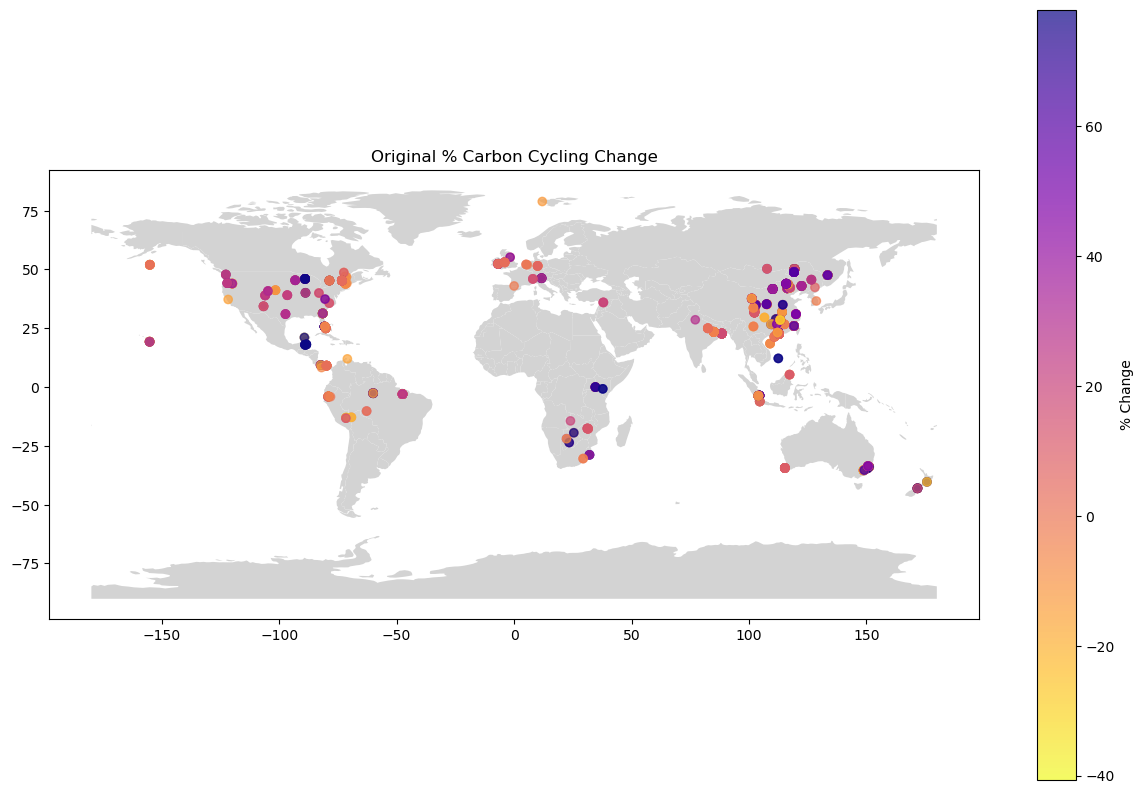

In [26]:
# df_map = df9.sort_values("occ") #present on top
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(15,10))
world.plot(ax=ax, color="lightgray")
# scatter = ax.scatter(df9['longitude'], df9['latitude'], c=df9['yi (response))'], alpha=0.9, cmap = 'Accent')
# scatter = ax.scatter(df9['longitude'], df9['latitude'], c=df9['yi (response)'], alpha=0.9, cmap='coolwarm', vmin=min(df9['yi (response)']), vmax=max(df9['yi (response)']))
scatter = ax.scatter(df9['longitude'], df9['latitude'], c=df9['yi (response)'], alpha=0.7, cmap='plasma_r', vmin=min(df9['yi (response)']), vmax=10*np.median(df9['yi (response)']))
cbar = plt.colorbar(scatter)
cbar.set_label('% Change')
plt.title('Original % Carbon Cycling Change')
# legend1 = ax.legend(*scatter.legend_elements(), title="$ Change in Carbon Cycling", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

### Plotting the Prediction

In [27]:
# print(x_test)
x_test['Prediction'] = pred4
print(x_test['Prediction'])

1087     23.378658
588      74.463066
766      -3.842431
275      -3.084183
666      17.267263
174      48.994972
1167     14.709926
341     -16.662180
259      -2.458119
532      -1.691234
791      23.320747
482     -12.885756
277       4.682148
696      12.790179
702      14.086580
413     234.649841
880      -1.988035
325      10.442543
779      -5.273938
320       7.330108
1174      3.097141
929       9.888220
207      17.273653
608       2.297235
402      -5.412251
173      40.885914
865       0.808680
899      -4.068828
1113     -5.590195
521     -17.918468
134      16.659678
1078    120.278976
1159     18.771517
1161      1.957130
137      59.406281
1051     30.404675
1073     13.888240
798      -0.056034
567      17.530346
764      -1.279616
731      14.422679
526       6.660676
19      350.493713
124      -7.021171
948     -12.951862
901       5.034328
445      -4.562754
896      14.622688
1084     19.298494
143      23.444510
1171      0.023818
116     172.363998
110      -1.

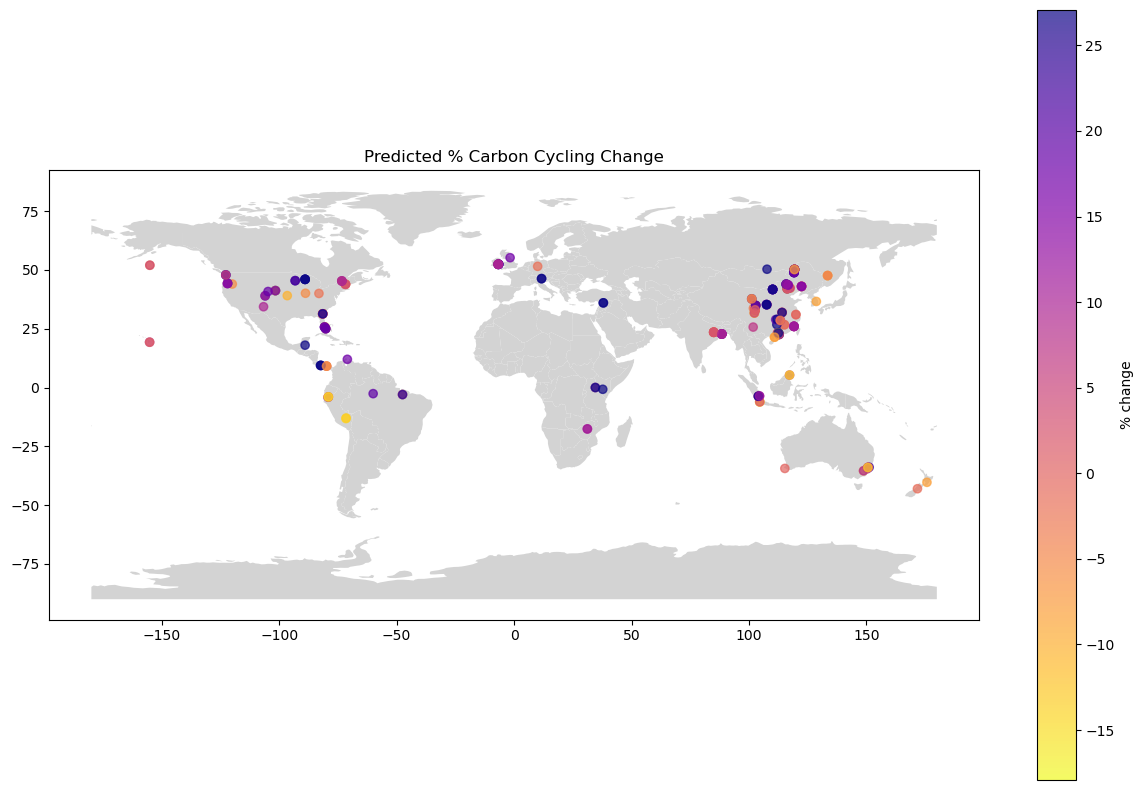

In [25]:
fig, ax = plt.subplots(figsize=(15,10))
world.plot(ax=ax, color="lightgray")
# scatter = ax.scatter(x_test['longitude'], x_test['latitude'], c=x_test['Prediction'], alpha=0.8, cmap='coolwarm')
scatter = ax.scatter(x_test['longitude'], x_test['latitude'], c=x_test['Prediction'], alpha=0.7, cmap='plasma_r', vmin=min(x_test['Prediction']), vmax=3*np.median(x_test['Prediction']))
cbar = plt.colorbar(scatter)
cbar.set_label('% change') # Format the ticks without decimal places
plt.title('Predicted % Carbon Cycling Change')
# legend1 = ax.legend(*scatter.legend_elements(), title="$ Change in Carbon Cycling", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Variable Importance

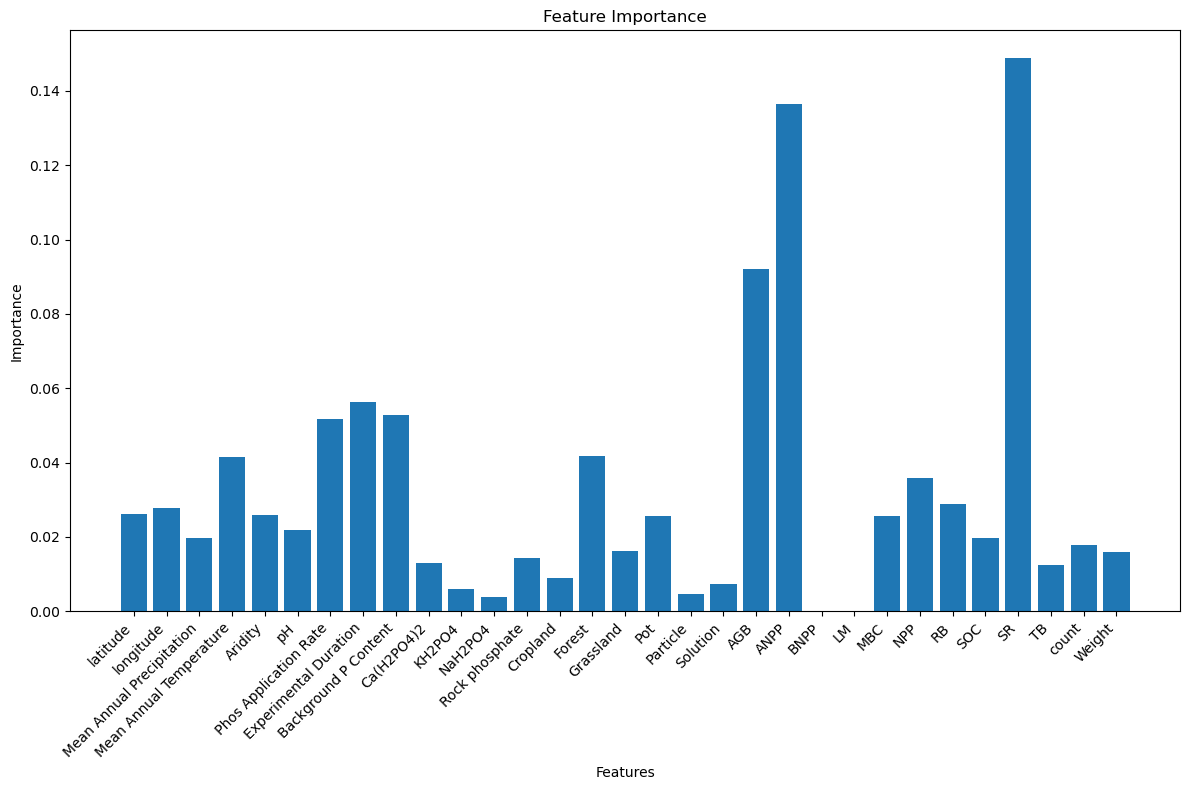

In [28]:
best_model = grid_search.best_estimator_
feature_importance = best_model.feature_importances_
# print(feature_importance)
pred_variables = df9.drop(columns=['yi (response)'])


plt.figure(figsize=(12, 8))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xticks(ticks=range(len(pred_variables.columns)), labels=pred_variables.columns, rotation=45, ha='right')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


###### AGB: Aboveground Biomass
###### ANPP: Aboveground net primary productivity 
###### BNPP: Beloground net primary productivity 
###### SR: Soil Respiration
###### It would seem the most important predictor variables are the type of terrestrial carbon cycling. 0.14 means that specific feature contributes 14% to the models prediction
###### interestingly, and this might be counter to the paper, the application rate and the background phosphorous content are the same importance. 

### True vs. Predicted Values

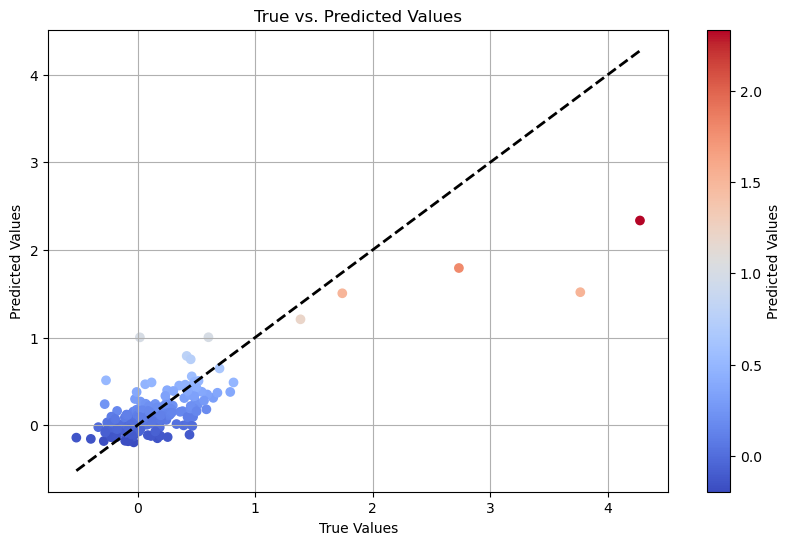

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, c=y_pred, cmap='coolwarm')
plt.colorbar(label='Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.grid(True)
plt.show()


### Learning Curve

[0]	validation_0-rmse:199.31542
[1]	validation_0-rmse:198.66671
[2]	validation_0-rmse:198.23778
[3]	validation_0-rmse:197.66009
[4]	validation_0-rmse:197.07257
[5]	validation_0-rmse:196.51040
[6]	validation_0-rmse:195.97164
[7]	validation_0-rmse:195.50784
[8]	validation_0-rmse:195.02535
[9]	validation_0-rmse:194.58646
[10]	validation_0-rmse:194.16181
[11]	validation_0-rmse:193.80039
[12]	validation_0-rmse:193.42607
[13]	validation_0-rmse:193.06450
[14]	validation_0-rmse:192.79747
[15]	validation_0-rmse:192.49441
[16]	validation_0-rmse:192.14748
[17]	validation_0-rmse:191.81289
[18]	validation_0-rmse:191.51839
[19]	validation_0-rmse:191.25169
[20]	validation_0-rmse:190.99290
[21]	validation_0-rmse:190.73794
[22]	validation_0-rmse:190.49735
[23]	validation_0-rmse:190.24123
[24]	validation_0-rmse:189.84154
[25]	validation_0-rmse:189.64480
[26]	validation_0-rmse:189.44691
[27]	validation_0-rmse:189.18471
[28]	validation_0-rmse:188.98678
[29]	validation_0-rmse:188.77743
[30]	validation_0-rm

/Users/johndocter/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[61]	validation_0-rmse:184.34732
[62]	validation_0-rmse:184.24060
[63]	validation_0-rmse:184.09818
[64]	validation_0-rmse:183.96313
[65]	validation_0-rmse:183.89683
[66]	validation_0-rmse:183.83969
[67]	validation_0-rmse:183.71276
[68]	validation_0-rmse:183.59151
[69]	validation_0-rmse:183.49417
[70]	validation_0-rmse:183.39442
[71]	validation_0-rmse:183.30219
[72]	validation_0-rmse:183.19570
[73]	validation_0-rmse:183.08039
[74]	validation_0-rmse:182.95451
[75]	validation_0-rmse:182.86510
[76]	validation_0-rmse:182.75247
[77]	validation_0-rmse:182.66098
[78]	validation_0-rmse:182.59887
[79]	validation_0-rmse:182.53432
[80]	validation_0-rmse:182.44759
[81]	validation_0-rmse:182.35364
[82]	validation_0-rmse:182.30642
[83]	validation_0-rmse:182.19939
[84]	validation_0-rmse:182.09312
[85]	validation_0-rmse:182.04346
[86]	validation_0-rmse:181.96002
[87]	validation_0-rmse:181.92046
[88]	validation_0-rmse:181.81262
[89]	validation_0-rmse:181.70860
[90]	validation_0-rmse:181.64352
[91]	valid

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


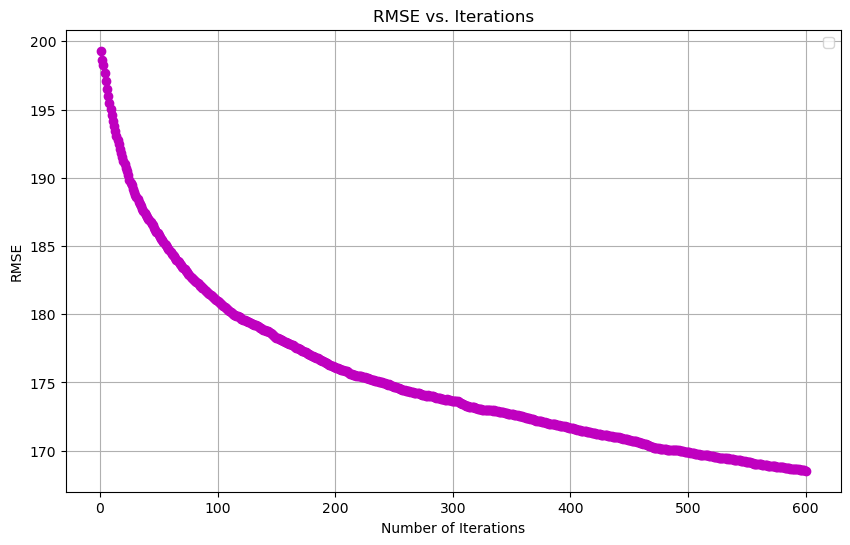

In [38]:
# In order to generate the learning curve, I have to rerun the model with the optimal hyperparameters, then extract the RMSE data. 
model2 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = 600, colsample_bytree = 0.8, eta=0.1, max_delta_step=0, max_depth=5, subsample=1.0)
model2.fit(x_train, y_train, eval_set=[(x_test, y_test)], eval_metric='rmse', sample_weight=weights)

y_pred2 = model2.predict(x_test)
r2 = r2_score(y_test, y_pred2)
print(r2)

results = model2.evals_result()
rmse = results['validation_0']['rmse']
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rmse) + 1), rmse, marker='o', linestyle='--', color = 'm')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE')
plt.title('RMSE vs. Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
k = 10 
mse_scores = cross_val_score(model2, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_scores = -mse_scores

# Print mean MSE and standard deviation
print("Mean Squared Error:", mse_scores.mean())
print("Standard Deviation of MSE:", mse_scores.std())

Mean Squared Error: 520.1656127518648
Standard Deviation of MSE: 377.40095697302564
